# Tải và load một số thư viện cần thiết

In [ ]:
!pip install openpyxl
!pip install unidecode
!pip install underthesea
!pip install adapter-transformers
!pip install adapters

In [51]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from transformers import RobertaForSequenceClassification
from transformers import get_scheduler
from adapters import AdapterConfig
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import re
import emoji
from underthesea import text_normalize

# Đọc dữ liệu 

In [52]:
train_path = "/kaggle/input/uit-vsmec/UIT-VSMEC/train_nor_811.xlsx"
valid_path = "/kaggle/input/uit-vsmec/UIT-VSMEC/valid_nor_811.xlsx"
test_path = "/kaggle/input/uit-vsmec/UIT-VSMEC/test_nor_811.xlsx"

In [53]:
train_df = pd.read_excel(train_path)
valid_df = pd.read_excel(valid_path)
test_df = pd.read_excel(test_path)

In [54]:
labels = train_df['Emotion'].unique()
labels

array(['Other', 'Disgust', 'Enjoyment', 'Anger', 'Surprise', 'Sadness',
       'Fear'], dtype=object)

In [55]:
print(train_df.head())

   Unnamed: 0    Emotion                                           Sentence
0         188      Other              cho mình xin bài nhạc tên là gì với ạ
1         166    Disgust  cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2        1345    Disgust  lo học đi . yêu đương lol gì hay lại thích học...
3         316  Enjoyment    uớc gì sau này về già vẫn có thể như cụ này :))
4        1225  Enjoyment  mỗi lần có video của con là cứ coi đi coi lại ...


In [56]:
print(valid_df.head())

   Unnamed: 0    Emotion                                           Sentence
0         941      Other  tính tao tao biết , chẳng có chuyện gì có thể ...
1         142  Enjoyment           lại là lào cai , tự hào quê mình quá :))
2        1164    Sadness                                     bị từ chối rồi
3         182  Enjoyment                         tam đảo trời đẹp các mem à
4         868      Other  đọc bình luận của thằng đó không thiếu chữ nào 😂😂


In [57]:
print(test_df.head())

   Unnamed: 0   Emotion                                           Sentence
0         713   Sadness                   người ta có bạn bè nhìn vui thật
1        1827  Surprise          cho nghỉ viêc mói đúng sao goi là kỷ luật
2        1166   Disgust                                         kinh vãi 😡
3         228      Fear  nhà thì không xa lắm nhưng chưa bao giờ đi vì ...
4        1942     Anger      bố không thích nộp đấy mày thích ý kiến không


In [58]:
print(train_df.columns)
print(valid_df.columns)
print(test_df.columns)

Index(['Unnamed: 0', 'Emotion', 'Sentence'], dtype='object')
Index(['Unnamed: 0', 'Emotion', 'Sentence'], dtype='object')
Index(['Unnamed: 0', 'Emotion', 'Sentence'], dtype='object')


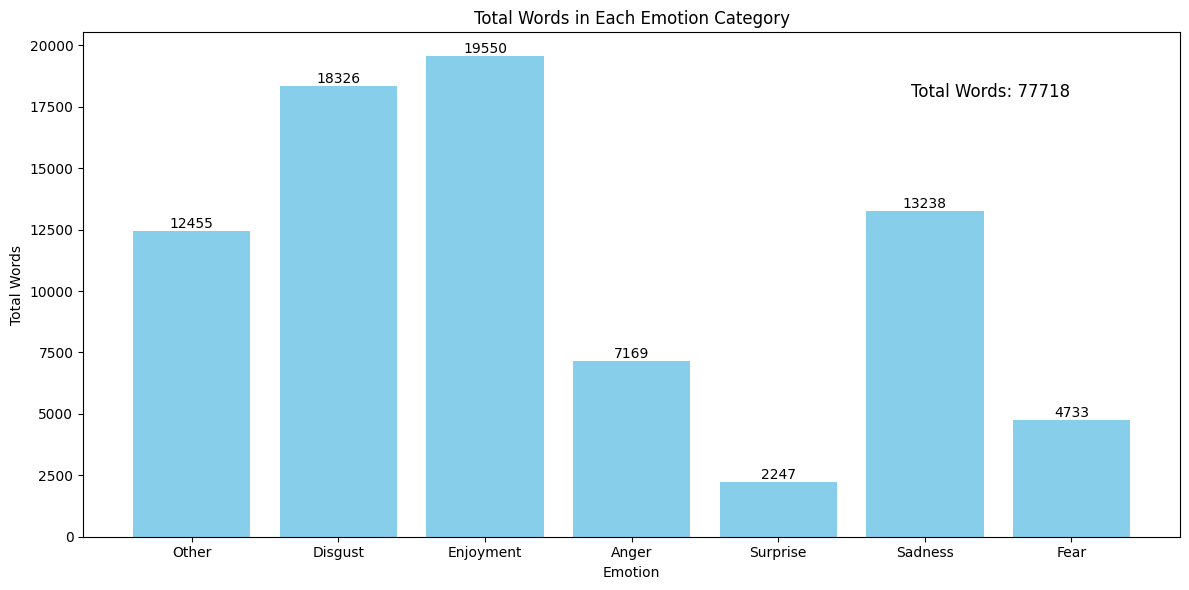

In [59]:
import matplotlib.pyplot as plt

# Đếm số từ trong mỗi nhãn Emotion
emotion_word_counts = {}

for emotion in train_df['Emotion'].unique():
    # Lọc các câu có nhãn Emotion tương ứng
    sentences = train_df[train_df['Emotion'] == emotion]['Sentence']
    
    # Đếm số từ trong mỗi câu và tính tổng cho mỗi nhãn
    total_words = sum(len(sentence.split()) for sentence in sentences)
    
    emotion_word_counts[emotion] = total_words

# Tính tổng số từ trong toàn bộ bộ dữ liệu
total_words_in_dataset = sum(emotion_word_counts.values())

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))  # Tăng kích thước biểu đồ để có thêm không gian
bars = plt.bar(emotion_word_counts.keys(), emotion_word_counts.values(), color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Total Words')
plt.title('Total Words in Each Emotion Category')

# Hiển thị số từ lên biểu đồ
for bar in bars:
    yval = bar.get_height()  # Lấy chiều cao của mỗi thanh (số từ)
    plt.text(bar.get_x() + bar.get_width() / 2, yval, str(int(yval)), ha='center', va='bottom', fontsize=10)

# Thêm tổng số từ vào góc phải trên
plt.text(0.9, 0.9, f'Total Words: {total_words_in_dataset}', ha='right', va='top', fontsize=12, color='black', transform=plt.gca().transAxes)

plt.tight_layout()  # Cập nhật layout để tránh cắt bớt nội dung
plt.show()


# **Tiền xử lí dữ liệu**

# Xử lí những kí tự bị lặp và cách gõ dấu

In [60]:
def normalize_repeated_chars(sentence):
    """
    Chuẩn hóa chuỗi bằng cách giảm các ký tự lặp lại liên tiếp về một ký tự duy nhất.
    """
    if pd.isnull(sentence):  # Kiểm tra nếu giá trị là null
        return sentence
    # Sử dụng regex để thay thế các ký tự lặp lại
    sentence = re.sub(r'(.)\1+', r'\1', sentence)
    
    # Sử dụng text_normalize để chuẩn hóa cách gõ dấu
    sentence = text_normalize(sentence)
    return sentence

# Chuẩn hóa thành chữ thường và xóa khoảng trắng dư thừa

In [61]:
def normalize_text_case_and_whitespace(sentence):
    """
    Chuẩn hóa chuỗi: 
    1. Chuyển chữ in hoa thành chữ thường.
    2. Loại bỏ khoảng trắng dư thừa (bao gồm khoảng trắng đầu/cuối và giữa các từ).
    """
    if not isinstance(sentence, str):
        return sentence  # Giữ nguyên nếu không phải chuỗi
    # Chuyển chữ in hoa thành chữ thường
    sentence = sentence.lower()

    # Loại bỏ các ký tự đặc biệt không cần thiết (ngoại trừ dấu câu ? ! . ,)
    #sentence = re.sub(r'[^a-zA-Z0-9\s?!.,]', '', sentence)
    
    # Loại bỏ khoảng trắng dư thừa
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

# Sửa lỗi chính tả và viết tắt

In [62]:
# Từ điển lỗi chính tả và viết tắt tiếng Việt
acronym_and_spelling_dict_vn = {
    "k": "không",
    "kô": "không",
    "ko": "không",
    "m": "mày",
    "n": "này",
    "t": "tao",
    "cóa": "có",
    "ngta": "người ta",
    "nta": "người ta",
    "cũnh": "cũng",
    "b": "bạn",
    "cũnh": "cũng",
    "cungc": "cũng",
    "cungz": "cũng",
    "cf": "cà phê",
    "coffee": "cà phê",
    "cafe": "cà phê",
    "caphe": "cà phê",
    "coffe": "cà phê",
    "pk": "biết",
    "bit": "biết",
    "bij": "biết",
    "a": "anh",
    "e": "em",
    "ae": "anh em",
    "hs": "học sinh",
    "per": "bà",
    "mí": "mới",
    "share": "chia sẻ",
    "cv": "công việc",
    "link": "đường dẫn",
    "kq": "kết quả",
    "tr": "triệu",
    "dzầy": "vầy",
    "mj": "mình",
    "ad": "bạn",
    "z": "vậy",
    "v": "vậy",
    "ah": "à",
    "đm": "đụ má",
    "dm": "đụ má",
    "dume": "đụ má",
    "dme": "đụ má",
    "ngulon": "ngu",
    "dẽ": "dễ",
    "fa": "không có người yêu",
    "haiz": "chán",
    "boss": "người giới tính thứ 3",
    "sứng": "xứng",
    "vler": "quá",
    "vl": "quá",
    "tr": "trời",
    "ok": "đồng ý",
    "crush": "người yêu mến",
    "dõ": "rõ",
    "mún": "muốn",
    "mn": "mọi người",
    "hông": "không",
    "hong": "không",
    "vãi": "quá",
    "trailer": "đoạn phim giới thiệu",
    "móa": "má",
    "chòi": "trời",
    "záy": "váy",
    "khầy": "thầy",
    "s": "sao",
    "anw": "dễ thương",
    "shit": "cức",
    "dt": "điện thoại",
    "dthoai": "điện thoại",
    "đt": "điện thoại",
    "lap": "laptop",
    "hem": "không",
    "hoy": "thôi",
    "hoi": "thôi",
    "tk": "thằng",
    "comt": "bình luận",
    "cmt": "bình luận",
    "nv": "như vậy",
    "ss": "so sánh",
    "babe": "em bé",
    "baby": "em bé",
    "bae": "em bé",
    "đc": "được",
    "đx": "được",
    "goi": "gọi",
    "mói": "mới",
    "dc": "được",
    "ca": "công an",
    "pạt": "phạt",
    "sgk": "sách giáo khoa",
    "vkl": "lắm",
    "zời": "trời",
    "khác hàg": "khách hàng",
    "đanh răng": "đánh răng",
    "pr": "quảng cáo",
    "h": "giờ",
    "phia": "khuya",
    "pv": "phục vụ",
    "danh": "dành",
    "đbh": "không bao giờ",
    "cs": "cuộc sống",
    "nge": "nghe",
    "đụ": "đủ",
    "chuc": "chúc",
    "bankon": "ban công",
    "xh": "xã hội",
    "yêuc": "yêu",
    "qué": "quá",
    "dặn đe": "răn đe",
    "chuỵ": "chị",
    "iem": "em",
    "ak": "à",
    "thă ́ c mă ́ c": "thắc mắc",
    "ta ̣ i": "tại",
    "thă ̀": "thằng",
    "no ́": "nó",
    "tră ́": "trắng",
    "va ̃ i": "vãi",
    "nhy ̃": "nhỉ",
    "mềnh": "mình",
    "huhu": "khóc",
    "haha": "buồn cười",
    "nhì": "nhìn",
    "kkk": "cười",
    "ju jin": "giữ gìn",
}


# Chuyển đổi emoji và emoticon

In [63]:
def correct_spelling_and_acronyms_vn(sentence):
    if not isinstance(sentence, str):
        return sentence  # Trả về văn bản nếu không phải chuỗi
    
    # Duyệt qua từ điển và thay thế các từ viết tắt hoặc lỗi chính tả
    for acronym, full_form in acronym_and_spelling_dict_vn.items():
        # Sử dụng biểu thức chính quy để thay thế các từ đúng và giữ nguyên vị trí
        # \b để đảm bảo thay thế các từ độc lập (không phải phần của từ khác)
        sentence = re.sub(r'\b' + re.escape(acronym) + r'\b', full_form, sentence)
    
    return sentence

In [64]:
# Từ điển emoticon -> dạng chữ
emoticon_dict = {
    ":)": ":slightly_smiling_face:",
    ":))": ":slightly_smiling_face:",
    ": )": ":slightly_smiling_face:",
    "=)": ":slightly_smiling_face:",
    "= )": ":slightly_smiling_face:", 
    "( =": ":slightly_smiling_face:",    
    "=(": ":frowning_face:",
    "= (": ":frowning_face:",
    ":<": ":frowning_face:",
    ": <": ":frowning_face:",
    ":>": ":upside-down_face:",
    ": >": ":upside-down_face:",
    ":(": ":frowning_face:",
    ": (": ":frowning_face:",
    ":D": ":grinning_face:",
    ":d": ":grinning_face:",
    ": d": ":grinning_face:",
    ":3": ":growing_heart:",
    ": 3": ":growing_heart:",
    "<3": ":heart_suit:",
    "< 3": ":heart_suit:",
    ";)": ":winking_face:",
    ":P": ":face_with_tongue:",
    ":' (": ":crying_face:",
    "XD": ":laughing_face:",
    ">:(": ":angry_face:",
    "-_-": ":expressionless_face:",
    "- _ -": ":expressionless_face:",
    "-.-": ":expressionless_face:",
    ":o": ":surprised_face:",
    ":- )": ":neutral_face:"
}

In [65]:
# Từ điển dịch từ dạng chữ sang tiếng Việt
translation_dict = {
    "slightly_smiling_face": "mỉm cười nhẹ",
    "smiling_face": "mỉm cười",
    "frowning_face": "buồn",
    "grinning_face": "cười lớn",
    "flushed_face": "đang suy nghĩ",
    "winking_face": "nháy mắt",
    "face_with_tongue": "thè lưỡi",
    "crying_face": "khóc",
    "laughing_face": "cười lớn",
    "angry_face": "tức giận",
    "surprised_face": "ngạc nhiên",
    "expressionless_face": "không cảm xúc",
    "disappointed_face": "thất vọng",
    "downcast_face_with_sweat": "lo lắng",
    "drooling_face": "thèm thuồng",
    "enraged_face": "giận dữ",
    "face_blowing_a_kiss": "hôn gió",
    "face_exhaling": "thở dài",
    "face_holding_back_tears": "cố kìm nước mắt",
    "face_savoring_food": "thưởng thức món ăn",
    "face_screaming_in_fear": "la hét vì sợ hãi",
    "face_vomiting": "nôn mửa",
    "face_with_diagonal_mouth": "không chắc chắn",
    "face_with_hand_over_mouth": "cười khúc khích",
    "face_with_open_eyes_and_hand_over_mouth": "ngạc nhiên",
    "face_with_open_mouth": "ngạc nhiên há hốc miệng",
    "face_with_peeking_eye": "tò mò",
    "face_with_raised_eyebrow": "nghi ngờ",
    "face_with_rolling_eyes": "mỉa mai",
    "face_with_spiral_eyes": "chóng mặt",
    "face_with_steam_from_nose": "tức giận",
    "face_with_symbols_on_mouth": "cực kì tức giận",
    "face_with_tears_of_joy": "cười ra nước mắt",
    "face_without_mouth": "không cảm xúc",
    "fearful_face": "sợ hãi",
    "grinning_face_with_smiling_eyes": "cười lớn",
    "grinning_face_with_big_eyes": "cười lớn với mắt to",
    "grinning_face_with_sweat": "cười ngượng",
    "growing_heart": "yêu thương",
    "heart_suit": "yêu thích",
    "hushed_face": "kinh ngạc",
    "kissing_cat": "yêu thích",
    "kissing_face": "mặt hôn",
    "kissing_face_with_closed_eyes": "mặt hôn với mắt nhắm",
    "kissing_face_with_smiling_eyes": "mặt hôn với mắt cười",
    "loudly_crying_face": "khóc lớn",
    "neutral_face": "bình thản",
    "persevering_face": "kiên trì",
    "red_heart": "yêu",
    "rolling_on_the_floor_laughing": "cười lăn lộn",
    "sad_but_relieved_face": "buồn nhưng nhẹ nhõm",
    "saluting_face": "mặt chào",
    "shushing_face": "yêu cầu im lặng",
    "sleeping_face": "ngủ",
    "slightly_frowning_face": "hơi cau mày",
    "smiling_cat_with_heart-eyes": "vui vẻ",
    "smiling_face_with_heart-eyes": "cười, yêu thích",
    "smiling_face_with_hearts": "cười với trái tim xung quanh",
    "smiling_face_with_open_hands": "cười với tay mở",
    "smiling_face_with_smiling_eyes": "cười với mắt cười",
    "smiling_face_with_sunglasses": "cười đeo kính râm",
    "smiling_face_with_tear": "cười rơi lệ",
    "smirking_face": "cười nhếch mép",
    "sneezing_face": "hắt hơi",
    "thumbs_up": "đồng ý",
    "thumbs_down": "không đồng ý",
    "tired_face": "mệt mỏi",
    "unamused_face": "không vui",
    "upside-down_face": "đùa giỡn",
    "woozy_face": "choáng váng",
    "yawning_face": "ngáp",
    "relieved_face": "nhẹ nhõm",
    "beaming_face_with_smiling_eyes": "cười rạng rỡ",
    "cloud_with_rain": "mưa",
    "grining_squinting_face": "cười lớn",
    "pensive_face": "buồn, chán nản",
    "weary_face": "thất vọng",
    "slepy_face": "buồn ngủ",
    "star-struck": "mừng rỡ",
    "anguished_face": "sợ",
    "smiling_face_with_horns": "tức giận dữ",
    "thinking_face": "đắng đo, suy nghĩ",
}


In [66]:
def normalize_emoji_emoticon(sentence):
    """
    Chuẩn hóa văn bản bằng cách:
    1. Loại bỏ emoji và emoticon trùng lặp.
    2. Chuyển emoji và emoticon duy nhất thành dạng chữ.
    """
    if not isinstance(sentence, str):
        return text  # Nếu không phải chuỗi, trả về như cũ
    
    # Tìm tất cả emoticon trong chuỗi
    emoticons = re.findall(r":[)(DPo'<>]+", sentence)
    # Loại bỏ trùng lặp trong danh sách emoticon
    unique_emoticons = list(dict.fromkeys(emoticons))
    
    # Thay thế emoticon bằng dạng chữ duy nhất
    for emoticon in unique_emoticons:
        if emoticon in emoticon_dict:
            sentence = sentence.replace(emoticon, emoticon_dict[emoticon])
    
    # Tìm tất cả emoji trong chuỗi
    emojis = re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', sentence)
    # Loại bỏ trùng lặp trong danh sách emoji
    unique_emojis = list(dict.fromkeys(emojis))
    
    # Chuyển emoji thành dạng chữ duy nhất
    for em in unique_emojis:
        sentence = sentence.replace(em, emoji.demojize(em))
    
    # Dịch dạng chữ sang tiếng Việt
    for english_word, vietnamese_translation in translation_dict.items():
        sentence = sentence.replace(f":{english_word}:", vietnamese_translation)
    
    return sentence

In [67]:
import re
stopword_file_path = "/kaggle/input/vietnamesestopword/vietnamese-stopwords.txt"

def remove_stopwords(sentence):
    """
    Hàm xử lý văn bản, loại bỏ các stopwords dựa trên tập stopword.txt.
    
    Args:
        text (str): Văn bản cần xử lý.
        stopword_file_path (str): Đường dẫn đến file stopword.txt.
    
    Returns:
        str: Văn bản đã được loại bỏ stopwords.
    """
    # Đọc danh sách stopwords từ file
    with open(stopword_file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())
    
    # Tách văn bản thành các từ
    sentence = sentence.split()
    
    # Loại bỏ stopwords
    processed_sentence = [sentence for sentence in sentence if sentence not in stopwords]
    
    # Ghép lại thành văn bản
    processed_sentence = ' '.join(processed_sentence)
    
    return processed_sentence


# Mã hóa nhãn cảm xúc

In [68]:
label_encoder = LabelEncoder()
train_df['Emotion'] = label_encoder.fit_transform(train_df['Emotion'])
valid_df['Emotion'] = label_encoder.fit_transform(valid_df['Emotion'])
test_df['Emotion'] = label_encoder.fit_transform(test_df['Emotion'])

In [69]:
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [70]:
for classs in label_encoder.classes_:
    print(classs)

Anger
Disgust
Enjoyment
Fear
Other
Sadness
Surprise


# Áp dụng các kỹ thuật tiền xử lí cho dữ liệu

In [71]:
def preprocess_data(df):
    # Áp dụng các kỹ thuật tiền xử lý cho dữ liệu
    df = df.apply(normalize_repeated_chars)
    df = df.apply(normalize_emoji_emoticon)
    df = df.apply(normalize_text_case_and_whitespace)
    #df = df.apply(correct_spelling_and_acronyms_vn) 
    #df = df.apply(remove_stopwords)
    return df 

In [72]:
train_df['Sentence'] = preprocess_data(train_df['Sentence'])
valid_df['Sentence'] = preprocess_data(valid_df['Sentence'])
test_df['Sentence'] = preprocess_data(test_df['Sentence'])

In [73]:
train_df['Sentence']

0                   cho mình xin bài nhạc tên là gì với ạ
1       cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2       lo học đi . yêu đương lol gì hay lại thích học...
3       ước gì sau này về già vẫn có thể như cụ này mỉ...
4       mỗi lần có video của con là cứ coi đi coi lại ...
                              ...                        
5543    đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544                               nhìn mặt héo queo luôn
5545    tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546                thích thân hình bos rồi nhan nhẹ nhõm
5547    ước mơ nhỏ nhoi của tao là được làm chị mà khô...
Name: Sentence, Length: 5548, dtype: object

In [74]:
valid_df['Sentence'].head()

0    tính tao tao biết , chẳng có chuyện gì có thể ...
1    lại là lào cai , tự hào quê mình quá mỉm cười nhẹ
2                                       bị từ chối rồi
3                           tam đảo trời đẹp các mem à
4    đọc bình luận của thằng đó không thiếu chữ nào...
Name: Sentence, dtype: object

In [75]:
test_df['Sentence'].head()

0                     người ta có bạn bè nhìn vui thật
1            cho nghỉ viêc mói đúng sao goi là kỷ luật
2                                     kinh vãi giận dữ
3    nhà thì không xa lắm nhưng chưa bao giờ đi vì ...
4        bố không thích nộp đấy mày thích ý kiến không
Name: Sentence, dtype: object

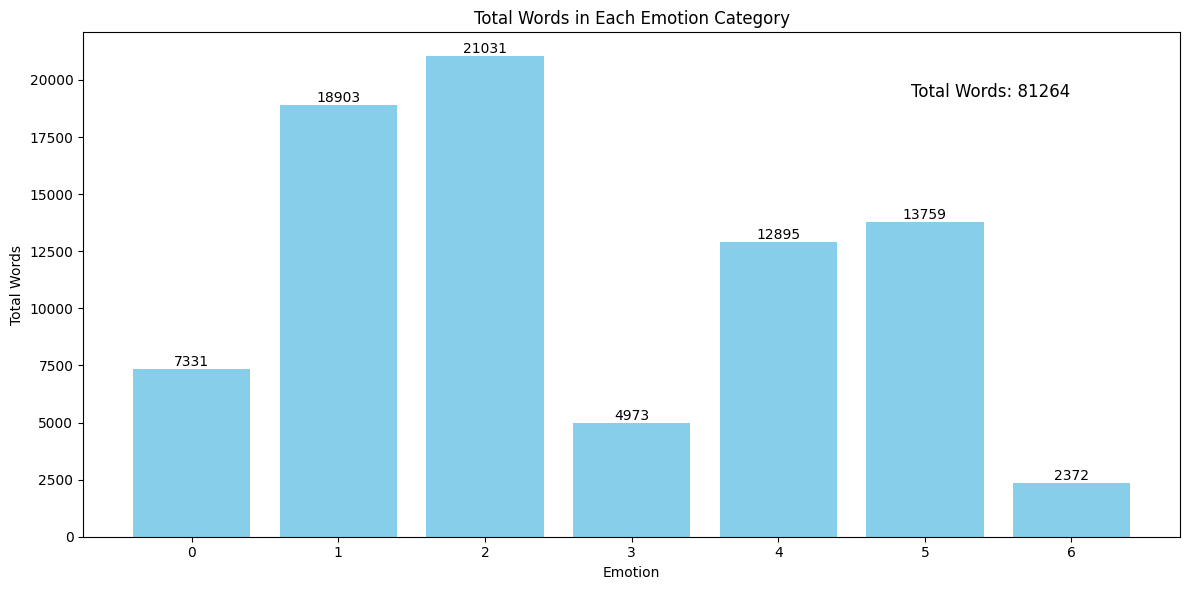

In [76]:
import matplotlib.pyplot as plt

# Đếm số từ trong mỗi nhãn Emotion
emotion_word_counts = {}

for emotion in train_df['Emotion'].unique():
    # Lọc các câu có nhãn Emotion tương ứng
    sentences = train_df[train_df['Emotion'] == emotion]['Sentence']
    
    # Đếm số từ trong mỗi câu và tính tổng cho mỗi nhãn
    total_words = sum(len(sentence.split()) for sentence in sentences)
    
    emotion_word_counts[emotion] = total_words

# Tính tổng số từ trong toàn bộ bộ dữ liệu
total_words_in_dataset = sum(emotion_word_counts.values())

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))  # Tăng kích thước biểu đồ để có thêm không gian
bars = plt.bar(emotion_word_counts.keys(), emotion_word_counts.values(), color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Total Words')
plt.title('Total Words in Each Emotion Category')

# Hiển thị số từ lên biểu đồ
for bar in bars:
    yval = bar.get_height()  # Lấy chiều cao của mỗi thanh (số từ)
    plt.text(bar.get_x() + bar.get_width() / 2, yval, str(int(yval)), ha='center', va='bottom', fontsize=10)

# Thêm tổng số từ vào góc phải trên
plt.text(0.9, 0.9, f'Total Words: {total_words_in_dataset}', ha='right', va='top', fontsize=12, color='black', transform=plt.gca().transAxes)

plt.tight_layout()  # Cập nhật layout để tránh cắt bớt nội dung
plt.show()


# **Load Model**

In [77]:
model = RobertaForSequenceClassification.from_pretrained('vinai/phobert-base', num_labels=num_classes, attn_implementation="eager")
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

# **Chuẩn bị dữ liệu**

In [80]:
class UITDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [81]:
max_len = 128
batch_size = 16

train_dataset = UITDataset(
    texts=train_df['Sentence'].to_numpy(),
    labels=train_df['Emotion'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

valid_dataset = UITDataset(
    texts=valid_df['Sentence'].to_numpy(),
    labels=valid_df['Emotion'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# **Set device**

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# **Set Optimizers**

In [83]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

epochs = 10
num_training_steps = epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

3470


# **Fine-tuning**

# Training loop

In [84]:
def train_model(model, dataloader, optimizer, lr_scheduler, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        # Chuyển dữ liệu lên device (CPU/GPU)
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['label'].to(device)  # Đảm bảo trường là 'labels'

        # Xóa gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits  # Truy cập logits từ SequenceClassifierOutput
        attention_maps = []
        attention_maps.append(outputs)

        # Tính loss
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, b_labels)

        # Backward pass và cập nhật trọng số
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


# Validating the Model

In [85]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_acc = 0
    total_count = 0

    with torch.no_grad():
        for batch in dataloader:
            # Chuyển dữ liệu lên device
            b_input_ids = batch['input_ids'].to(device)
            b_attention_mask = batch['attention_mask'].to(device)
            b_labels = batch['label'].to(device)  # Sửa 'label' thành 'labels' nếu đúng

            # Forward pass
            outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits  # Truy cập logits từ SequenceClassifierOutput

            # Dự đoán và tính accuracy
            preds = torch.argmax(logits, dim=1)
            total_acc += (preds == b_labels).sum().item()
            total_count += b_labels.size(0)

    return total_acc / total_count


# Training

In [86]:
import time

epochs = 10
total_time = []

start_timee = time.time()
for epoch in range(epochs):
    # Ghi lại thời gian bắt đầu của epoch
    start_time = time.time()
    
    # Huấn luyện mô hình và đánh giá
    train_loss = train_model(model, train_loader, optimizer, lr_scheduler, device)
    val_acc = evaluate_model(model, valid_loader, device)

    # Ghi lại thời gian kết thúc của epoch
    end_time = time.time()
    
    # Tính toán thời gian huấn luyện
    epoch_time = end_time - start_time

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Time taken for epoch {epoch + 1}: {epoch_time:.2f} seconds")
    
end_timee = time.time()
total_time = end_timee - start_timee

print(f"Total time: {total_time:.2f} seconds")

Epoch 1/10
Train Loss: 1.5302
Validation Accuracy: 0.5802
Time taken for epoch 1: 133.68 seconds
Epoch 2/10
Train Loss: 1.0611
Validation Accuracy: 0.6166
Time taken for epoch 2: 136.21 seconds
Epoch 3/10
Train Loss: 0.8175
Validation Accuracy: 0.6035
Time taken for epoch 3: 136.38 seconds
Epoch 4/10
Train Loss: 0.6182
Validation Accuracy: 0.6166
Time taken for epoch 4: 136.08 seconds
Epoch 5/10
Train Loss: 0.4613
Validation Accuracy: 0.6356
Time taken for epoch 5: 135.97 seconds
Epoch 6/10
Train Loss: 0.3364
Validation Accuracy: 0.6385
Time taken for epoch 6: 136.19 seconds
Epoch 7/10
Train Loss: 0.2450
Validation Accuracy: 0.6224
Time taken for epoch 7: 136.12 seconds
Epoch 8/10
Train Loss: 0.1827
Validation Accuracy: 0.6472
Time taken for epoch 8: 135.95 seconds
Epoch 9/10
Train Loss: 0.1458
Validation Accuracy: 0.6443
Time taken for epoch 9: 136.12 seconds
Epoch 10/10
Train Loss: 0.1252
Validation Accuracy: 0.6443
Time taken for epoch 10: 136.17 seconds
Total time: 1358.86 seconds


In [87]:
test_dataset = UITDataset(
    texts=test_df['Sentence'].to_numpy(),
    labels=test_df['Emotion'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [88]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    total_correct = 0
    total_samples = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Không tính gradient
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Lấy logits từ output của model

            # Dự đoán nhãn
            preds = torch.argmax(logits, dim=1)
            pred_labels.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

            # Tính số lượng dự đoán đúng
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    # Tính accuracy
    accuracy = total_correct / total_samples
    return true_labels, pred_labels


In [89]:
true_labels, pred_labels = evaluate_model(model, test_loader, device)

In [90]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Tính accuracy và F1-Score
test_accuracy = accuracy_score(true_labels, pred_labels)
test_f1 = f1_score(true_labels, pred_labels, average='weighted')  # Chọn 'weighted', 'macro', hoặc 'micro'

# In báo cáo chi tiết
report = classification_report(true_labels, pred_labels, target_names=label_encoder.classes_)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print("Classification Report:")
print(report)


Test Accuracy: 0.6291
Test F1-Score: 0.6280
Classification Report:
              precision    recall  f1-score   support

       Anger       0.45      0.42      0.44        40
     Disgust       0.57      0.58      0.57       132
   Enjoyment       0.70      0.71      0.70       193
        Fear       0.59      0.65      0.62        46
       Other       0.55      0.51      0.53       129
     Sadness       0.73      0.74      0.74       116
    Surprise       0.67      0.65      0.66        37

    accuracy                           0.63       693
   macro avg       0.61      0.61      0.61       693
weighted avg       0.63      0.63      0.63       693



In [91]:
model.save_pretrained("nlp_uit_vsmec_model")
tokenizer.save_pretrained("nlp_uit_vsmec_model")

('nlp_uit_vsmec_model/tokenizer_config.json',
 'nlp_uit_vsmec_model/special_tokens_map.json',
 'nlp_uit_vsmec_model/vocab.txt',
 'nlp_uit_vsmec_model/bpe.codes',
 'nlp_uit_vsmec_model/added_tokens.json')